<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/GCP_Training__Descriptive_Predictive_Prescriptive_Analysis_Workflows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adswerve Google Cloud Platform Training for Marketers
## Descriptive, Predictive, Prescriptive Analysis Workflows

Click the <img src="https://storage.googleapis.com/adswerve-oculi-public/colab_play.png" width="22px" height="22px" /> button to run a cell, or click the cell then press "Shift + Enter"


# Set-up

In [14]:
#@title Authenticate + Dependencies
from google.colab import auth
auth.authenticate_user()

from IPython.display import clear_output
from IPython.core.display import display, HTML
from google.cloud import bigquery
from google.cloud.bigquery import magics
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas as pd

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import seaborn as sns
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = (14,8)

In [12]:
#@title Set defaults
billable_project_id = "as-dev-pat" #@param {type:"string"}
project_id = "bigquery-public-data" #@param {type:"string"}
bq_enabled_ga_view_id = "google_analytics_sample" #@param {type:"string"}
max_gb_query_size =  1#@param {type:"integer"}
max_gb_query_size = max_gb_query_size * np.power(2,30)
project_id = project_id.strip()
billable_project_id = billable_project_id.strip()
bq_enabled_ga_view_id = bq_enabled_ga_view_id.strip()
params = { 'project_id' : project_id, 'bq_view': bq_enabled_ga_view_id }

#magics.context.progress_bar_type = "tqdm"
magics.context.project = billable_project_id
magics.context.default_query_job_config.maximum_bytes_billed = max_gb_query_size 

# Descriptive Analysis

Example SQL query:
```
SELECT date, SUM(totals.pageviews)
FROM `project.dataset.table`
GROUP BY date, ORDER BY date
```


In [3]:
#@title query `ga_sessions` daily tables
start_date = "2016-08-01" #@param {type:"date"}
end_date = "2017-07-31" #@param {type:"date"}
#@markdown Enter `REGEXP_CONTAINS()` used in query:
earned_source = "facebook|google|partner|dfa|dbm" #@param {type:"string"}
earned_medium = "cpc|affiliate|display|cpm" #@param {type:"string"}
owned_source = "facebook|google|youtube|twitter" #@param {type:"string"}
owned_medium = "organic|referral|owned|social" #@param {type:"string"} 
primary_countries = "united states" #@param {type:"string"} 
#@markdown *OPTIONAL:* Add custom SQL to the `SELECT` statement:
custom_SQL = ""#@param {type:"string"} 
#@markdown Dry Run first to test size of query:
is_dry_run = False #@param {type:"boolean"} 
start_date = start_date.replace("-","")
end_date = end_date.replace("-","")

query = """
SELECT
  date,
  COUNT(DISTINCT fullVisitorId) AS users,
  COUNT(*) as sessions,
  
  SUM(totals.bounces) AS bounces,
  SUM(totals.pageviews) AS pageviews,
  SUM(totals.newVisits) AS newVisits,
  AVG(totals.timeOnSite)/60 AS avgTimeOnSite,
  COALESCE(SUM(totals.totalTransactionRevenue / 1e6),0) AS revenue,
  COALESCE(SUM(totals.transactions),0) AS transactions,
  SUM(IF(REGEXP_CONTAINS(LOWER(trafficSource.source) , '{0}') AND REGEXP_CONTAINS(LOWER(trafficSource.medium) , '{1}'), 1, 0)) AS earned,
  SUM(IF(REGEXP_CONTAINS(LOWER(trafficSource.source) , '{2}') AND REGEXP_CONTAINS(LOWER(trafficSource.medium), '{3}'), 1, 0)) AS owned,
  SUM(IF(trafficSource.isTrueDirect,1,0)) as trueDirect,
    --device.deviceCategory as device,
  SUM(IF( device.deviceCategory = "desktop",1,0)) as device_desktop_visits,
  SUM(IF( device.deviceCategory = "mobile",1,0)) as device_mobile_visits,
  SUM(IF( device.deviceCategory = "table",1,0)) as device_tablet_visits,

  --  device.operatingSystem as os,
  SUM(IF( device.operatingSystem = "Windows",1,0)) as OS_windows_visits,
  SUM(IF( device.operatingSystem = "Macintosh",1,0)) as OS_mac_visits,
  SUM(IF( device.operatingSystem = "Android",1,0)) as OS_android_visits,
  SUM(IF( device.operatingSystem = "iOS",1,0)) as OS_iOS_visits,
  SUM(IF( device.operatingSystem = "Chrome OS",1,0)) as OS_chromeOS_visits,
  SUM(IF( NOT REGEXP_CONTAINS(device.operatingSystem, "(Windows|Macintosh|Android|iOS|Chrome OS)"),1,0)) as OS_other_visits,

  --  device.browser,
  SUM(IF( device.browser = "Chrome",1,0)) as browser_chrome_visits,
  SUM(IF( REGEXP_CONTAINS(device.browser,"Safari"),1,0)) as browser_safari_visits,
  SUM(IF( device.browser = "Edge",1,0)) as browser_edge_visits,
  SUM(IF( device.browser = "Firefox",1,0)) as browser_firefox_visits,
  SUM(IF( NOT REGEXP_CONTAINS(device.browser, "(Chrome|Safari|Edge|Firefox)"),1,0)) as browser_other_visits,

  --  geoNetwork.country,
  SUM(IF( REGEXP_CONTAINS(LOWER(geoNetwork.country),"{4}"),1,0)) as country_primary_visits,
  SUM(IF( NOT REGEXP_CONTAINS(LOWER(geoNetwork.country),"{4}"),1,0)) as country_secondary_visits,

  SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) ) IN (5,6,7,8,9,10) THEN 1 ELSE 0 END) AS morningVisits,
  SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) )  IN (11,12,13,14,15,16) THEN 1 ELSE 0 END) AS dayVisits,
  SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) ) IN (17,18,19,20,21,22) THEN 1 ELSE 0 END) AS eveningVisits,
  SUM(CASE WHEN EXTRACT(HOUR FROM TIMESTAMP_SECONDS(visitStartTime) ) IN (23,24,1,2,3,4) THEN 1 ELSE 0 END) AS twilightVisits,
  -- CUSTOM SQL LINES:
  {5}
FROM `{6}.{7}.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '{8}' and '{9}'
AND totals.visits = 1 -- session has interaction event
GROUP BY date
"""

query = query.format(
    earned_source, 
    earned_medium, 
    owned_source, 
    owned_medium, 
    primary_countries,
    custom_SQL,
    project_id, 
    bq_enabled_ga_view_id, 
    start_date, 
    end_date
  )


client = bigquery.Client(project=billable_project_id)
job_config = bigquery.QueryJobConfig()
job_config.maximum_bytes_billed = max_gb_query_size
if (is_dry_run):
  job_config.dry_run = True
  job_config.use_query_cache = False
  query_job = client.query(query, job_config=job_config)
  processed = query_job.total_bytes_processed
  print("Job is estimated at {} GB, ~${} for the query".format(round(processed/ np.power(2,30),2), round(processed / np.power(2,40) * 5,4)))
else:
  job_config.dry_run = False
  job_config.use_query_cache = True
  query_job = client.query(query, job_config=job_config)  # API request
  df = query_job.to_dataframe().sort_values(by='date')
  df['date'] = pd.to_datetime(df['date'])
  df = df.sort_values(by='date').reset_index(drop=True)
  clear_output()
  df.head()#.style.set_properties(**{'background-color': 'red'}, subset=['revenue'])

In [4]:
#@title `.info()` , `.describe()` { run: "auto" }
#@markdown Descriptive statistics or Dataframe schema information:
column_select = "revenue" #@param ['all', 'users', 'sessions', 'bounces', 'pageviews', 'newVisits','avgTimeOnSite', 'revenue', 'transactions', 'earned', 'owned','trueDirect', 'device_desktop_visits', 'device_mobile_visits','device_tablet_visits', 'OS_windows_visits', 'OS_mac_visits','OS_android_visits', 'OS_iOS_visits', 'OS_chromeOS_visits','OS_other_visits', 'browser_chrome_visits', 'browser_safari_visits','browser_edge_visits', 'browser_firefox_visits', 'browser_other_visits','country_primary_visits', 'country_secondary_visits', 'morningVisits','dayVisits', 'eveningVisits', 'twilightVisits']
if (column_select == "all"):
  column_select = df.columns.values
else:
  column_select = [column_select]

describe_stats = True #@param {type:"boolean"}
if (describe_stats): 
  display(df[column_select].describe(include="all", datetime_is_numeric=True))
else:
  display(df[column_select].info())

,revenue
count,365.000000
mean,4852.765014
std,4900.312479
min,0.000000
25%,1917.980000
50%,4202.500000
75%,6112.690000
max,51910.340000


Weekend revenue is 154622, which is 9% of total revenue.
Outlier revenue is 175615, 10% of total revenue at: 1771259.
256/365 data points remain with a SUM of revenue at 1441022


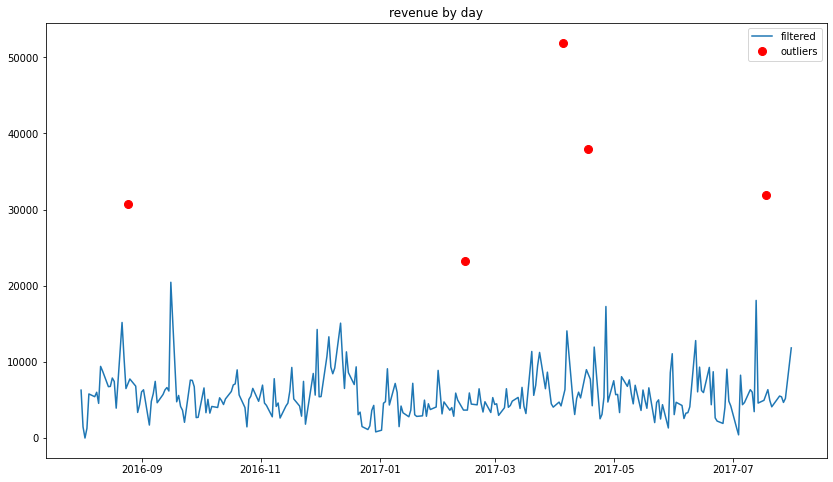

In [5]:
#@title Outlier detection using quantiles { run: "auto" }
column_select = "revenue" #@param ['users', 'sessions', 'bounces', 'pageviews', 'newVisits','avgTimeOnSite', 'revenue', 'transactions', 'earned', 'owned','trueDirect', 'device_desktop_visits', 'device_mobile_visits','device_tablet_visits', 'OS_windows_visits', 'OS_mac_visits','OS_android_visits', 'OS_iOS_visits', 'OS_chromeOS_visits','OS_other_visits', 'browser_chrome_visits', 'browser_safari_visits','browser_edge_visits', 'browser_firefox_visits', 'browser_other_visits','country_primary_visits', 'country_secondary_visits', 'morningVisits','dayVisits', 'eveningVisits', 'twilightVisits']
lower = 0 #@param {type:"slider", min:0, max:0.15, step:0.001}
upper = 0.984 #@param {type:"slider", min:0.85, max:1, step:0.001}
exclude_weekends = True #@param {type:"boolean"}
print("Weekend {0} is {1}, which is {2}% of total {0}.".format(
    column_select,
    int(round(df[~(df['date'].dt.dayofweek < 5)][column_select].sum(),2)),
    int(round(np.divide(df[~(df['date'].dt.dayofweek < 5)][column_select].sum(), df[column_select].sum()),2) * 100)
))
if (exclude_weekends):
  df2 = df.loc[df['date'].dt.dayofweek < 5].reset_index(drop=True).copy()
else:
  df2 = df.copy()

y = df2[column_select]
not_outlier = y.between(y.quantile(lower), y.quantile(upper))

merge = df2.merge(df2[not_outlier][['date',column_select]], on="date", how='outer')
merge.rename(columns={column_select+'_x': 'outliers', column_select+'_y': 'filtered'}, inplace=True)
merge['filtered'] = merge['filtered'].interpolate()

plt.figure(figsize=(14,8))
plt.axes()
plt.plot('date', 'filtered', '-', label='filtered', data=merge)
plt.plot('date', 'outliers', 'o',markersize=8, color='red', label='outliers', data=merge[~not_outlier])

print("Outlier {0} is {1}, {3}% of total {0} at: {2}.".format(
    column_select,
    int(round(df2[~not_outlier][column_select].sum())),
    int(round(df[column_select].sum())),
    int(round(np.divide(df2[~not_outlier][column_select].sum(), df[column_select].sum()),2) * 100)                 
  )
)
print(str(y[not_outlier].size) + "/" + str(len(df)) + " data points remain with a SUM of " + column_select + " at " + str(int(round(df2[not_outlier][column_select].sum()))))
filtered = df2[not_outlier]
filtered = filtered.set_index('date').resample('D').sum().replace(0, np.nan).interpolate().reset_index()
plt.title("{} by day".format(column_select))
plt.legend()
plt.show()


# Predictive Analysis

### Forecasting

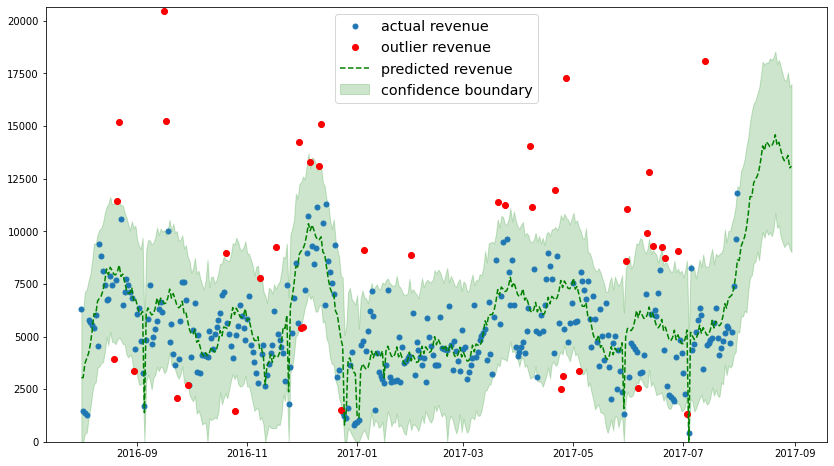

In [6]:
#@title Generate a forecast using Facebook Prophet
#column = "revenue" #@param ["users", "bounces", "pageviews", "newVisits", "avgTimeOnSite", "revenue", "transactions"]
forecast_window =  30 #@param {type:"integer"}
mcmc_samples =   25#@param {type:"integer"}
changepoint_prior_scale = 0.01 #@param {type:"number"}
seasonality_prior_scale = 1.0 #@param {type:"number"}
yearly_seasonality =  True#@param {type:"boolean"}

forecast_df = filtered[['date',column_select]].rename(columns={'date': 'ds', column_select: 'y'})
m = Prophet(
    mcmc_samples=mcmc_samples, 
    changepoint_prior_scale=changepoint_prior_scale,
    yearly_seasonality=yearly_seasonality,
    seasonality_prior_scale=seasonality_prior_scale
  )
m.add_country_holidays(country_name='US')
m.fit(forecast_df)
future = m.make_future_dataframe(periods=forecast_window)
forecast = m.predict(future)
clear_output()
combine = forecast.merge(forecast_df, on='ds')
filter = combine.loc[(combine.y > combine.yhat_upper) | (combine.y < combine.yhat_lower)][['ds','y']]
forecast.yhat_lower.clip(lower=0, inplace=True)
plt.figure(figsize=(14,8))
plt.axes(ylim=(-1,max(combine.y.max(),forecast.yhat.max(), forecast.yhat_upper.max())*1.01))

# plot the actuals
plt.plot('ds', 'y', '.', label="actual " + column_select, data=combine, markersize=10)

# plot the outliers 
plt.plot('ds', 'y','o',c='r', label='outlier ' + column_select, data=filter)

# plot the rolling average mean 
plt.plot('ds', 'yhat', '--b', color='g', label='predicted ' + column_select, data=forecast)

# plot the Prophet model forecast boundaries
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper,color='g', alpha=0.2, label='confidence boundary')

plt.legend(fontsize='x-large')
plt.show()


#### Model Inspection

In [7]:
#@title View model components
plot_components_plotly(m, forecast, figsize=(900,185))

#### Residual Error Analysis

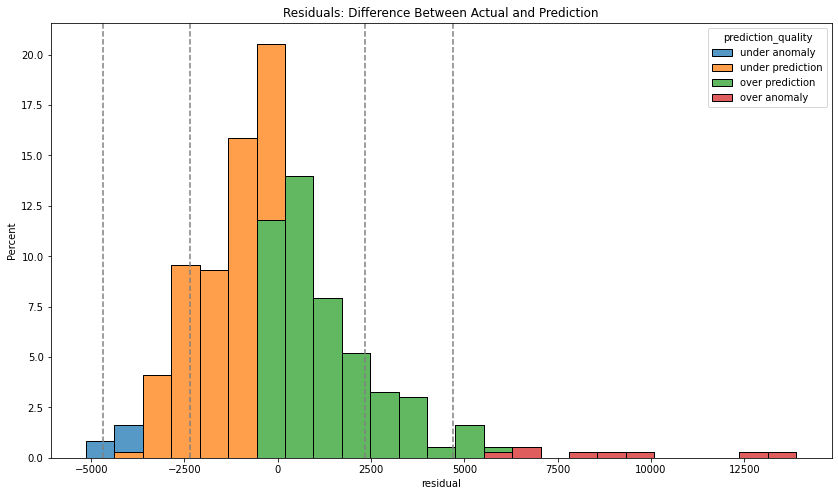

In [15]:
#@title Residual Analysis: Distribution of Errors {'run':'auto'}
residuals = combine['y'] - combine['yhat']
#_ = residuals.hist(bins=25)

combine['residual'] = pd.DataFrame({'residuals': residuals})
prediction_quality = ['under anomaly', 'under prediction', 'over prediction', 'over anomaly'] #@param 
prediction_quality_thresholds = [0, .02, .5, .98, 1] #@param 
combine['prediction_quality'] = pd.qcut( combine['residual'], q=prediction_quality_thresholds, labels=prediction_quality)
standard_deviation = True #@param {type:"boolean"}
kernel_density_estimator = False #@param {type:"boolean"}
aggregate_statistic = "percent" #@param ["count", "frequency", "probability", "percent", "density"]
sns.histplot(data=combine, bins=25, x='residual', hue='prediction_quality', kde=kernel_density_estimator, stat=aggregate_statistic, multiple='stack')

if (standard_deviation):
  counts, bins = np.histogram(residuals)
  mids = 0.5*(bins[1:] + bins[:-1])
  probs = counts / np.sum(counts)
  mean = np.sum(probs * mids)  
  sd = np.sqrt(np.sum(probs * (mids - mean)**2))
  sds = sd*np.array([1,2,-1,-2]) # 1,2 STD
  for xc in sds:
    plt.axvline(x=xc, ls='--', color='grey')
plt.title('Residuals: Difference Between Actual and Prediction')
plt.show()

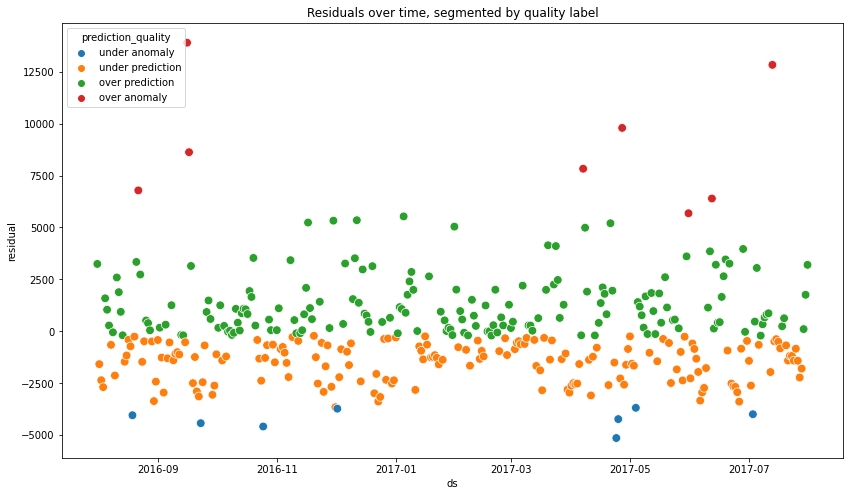

In [16]:
#@title Residual Analysis: Timeline with Quality Labels
sns.scatterplot(data=combine, x='ds', y='residual', hue='prediction_quality',s=75 ,)
plt.title('Residuals over time, segmented by quality label')
plt.show()

# Prescriptive Analysis

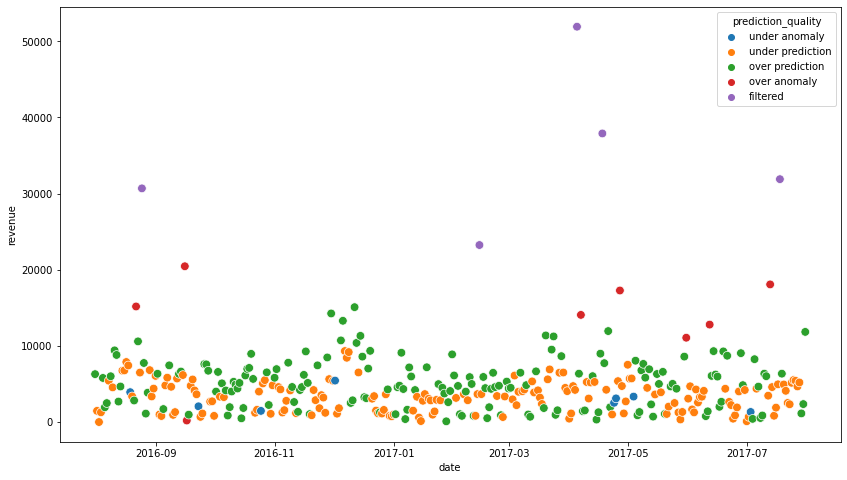

In [17]:
#@title Prescriptive Analysis: Full Timeline with Model Prediction Quality & Filter Labels
filter_label = "filtered" #@param {'type':'string'}
if (len(combine.prediction_quality.cat.categories) <= len(prediction_quality)):
  combine['prediction_quality'] = combine['prediction_quality'].cat.add_categories(filter_label) 
final_df = df.reset_index().merge(combine.reset_index(), how='left',on='index').drop('index',axis=1)
final_df.at[final_df[final_df['date'].isin(df2.loc[~not_outlier]['date'].values)].index, 'prediction_quality'] = filter_label
_ = sns.scatterplot(data=final_df[['date', column_select, 'prediction_quality']], x='date', y=column_select, hue='prediction_quality', s=75)

The Classifer had 100.0% accuracy in predicting revenue labels.



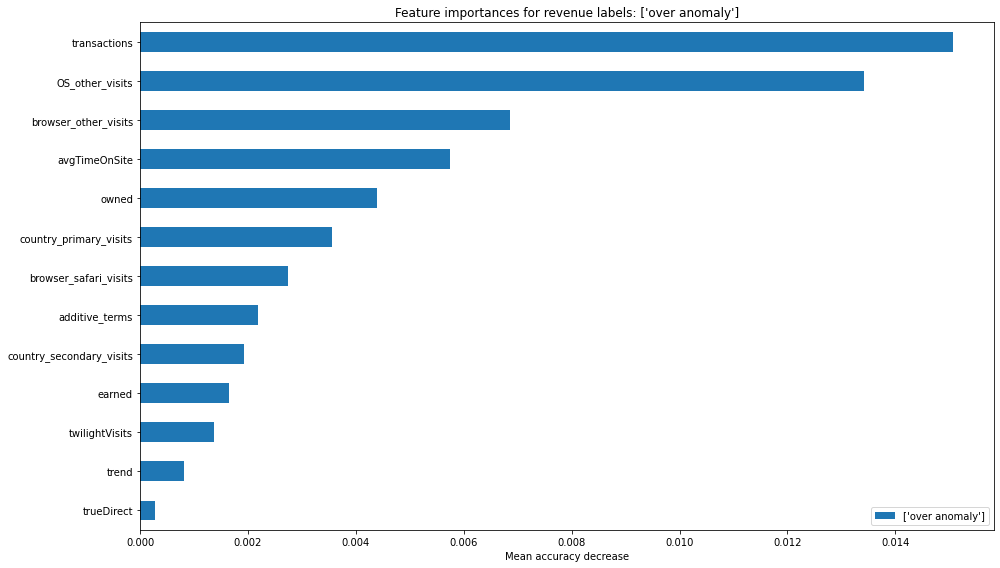

In [18]:
#@title Random Forest Classifier: Feature Importances {'run':'auto'}
label_is_in = [prediction_quality[-1]] #@param {type:"raw"}
max_tree_depth =  5#@param {type:"slider", min:2, max:15, step:1}
correlation_threshold = 95 #@param {type:"slider", min:60, max:99, step:1}
class_weight = "balanced_subsample" #@param ["\"balanced\"", "\"balanced_subsample\"", "None"] {type:"raw", allow-input: true}
correlation_threshold /= 100

# author NISHA DAGA https://stackoverflow.com/a/44674459/13280099
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

feature_set = final_df.drop(['date', 'yhat', 'y', 'residual', 'yhat_upper', 'yhat_lower', 'additive_terms_lower','additive_terms_upper','yearly_lower', 'yearly_upper','ds', column_select, 'trend_upper', 'trend_lower'], axis=1)
feature_set = feature_set.loc[:, (feature_set != 0).any(axis=0)]
correlation(feature_set,correlation_threshold)
feature_set.loc[feature_set['prediction_quality'].isin(label_is_in),'label'] = 1
y = feature_set.drop('prediction_quality',axis=1).fillna(0)['label']
X = feature_set.drop(['prediction_quality', 'label'],axis=1)

clf = RandomForestClassifier(max_depth=max_tree_depth, random_state=42, class_weight=class_weight)
clf.fit(X,y)
print("The Classifer had {}% accuracy in predicting {} labels.\n".format(round(clf.score(X,y)*100,2), column_select))

feature_names = [f'{i}' for i in X.columns]
result = permutation_importance(
    clf, X, y, n_repeats=10, random_state=42, n_jobs=-1)
forest_importances = pd.Series(result.importances_mean, index=feature_names)
import_df = forest_importances.sort_values(ascending=True).loc[forest_importances > 0]
if (len(import_df) > 0):
  fig, ax = plt.subplots()
  forest_importances.sort_values(ascending=True).loc[forest_importances > 0].plot.barh(ax=ax, label=str(label_is_in))
  ax.set_title("Feature importances for " + column_select + " labels: " + str(label_is_in))
  ax.set_xlabel("Mean accuracy decrease")
  fig.tight_layout()
  plt.legend()
  plt.show()
else:
  print('Failed to identify relevant features toward the label for ' + column_select)
